# Detección de spam con Deep Learning (DL)

Este cuaderno demuestra el proceso de construcción y evaluación de múltiples modelos de redes neuronales para la detección de spam. El conjunto de datos se preprocesa, se vectoriza y luego se utiliza para entrenar y evaluar diferentes modelos de DL.

---

## 1. Importación de librerías

El código comienza importando las librerías necesarias para el procesamiento de datos, el modelo de red neuronal y la evaluación.

In [44]:
import tratarDatos
import os
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics

# Carga y división de datos
xtrain, xtest, ytrain, ytest = tratarDatos.combinar_y_dividir_datos()

---

## 2. Tokenización y Preprocesamiento

El texto se convierte en secuencias numéricas y se rellenan para tener una longitud fija.

In [45]:
# Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xtrain)

# Conversión a secuencias
train_secuencia = tokenizer.texts_to_sequences(xtrain)
test_secuencia = tokenizer.texts_to_sequences(xtest)

# Optimización de longitud de secuencia
max_len = 100   # Longitud máxima fija
x_train = pad_sequences(train_secuencia, maxlen=max_len, truncating="post")
x_test = pad_sequences(test_secuencia, maxlen=max_len, truncating="post")

# Conversión a arrays de numpy
y_train = np.array(ytrain, dtype=np.float16)
y_test = np.array(ytest, dtype=np.float16)  # Convertir a float16 para ahorrar RAM

# Conversión a tensores de PyTorch
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float16)
X_val = torch.tensor(x_test, dtype=torch.long)
y_val = torch.tensor(y_test, dtype=torch.float16)

# Creación de DataLoaders
batch_size = 32
train_data = TensorDataset(x_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, pin_memory=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, pin_memory=True)

---

## 3. Definición de Modelos

Se definen tres arquitecturas de modelos: LSTM, RNN y MLP.

In [46]:
# Modelo LSTM
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_size=1, n_layers=2, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.lstm(embedded)
        out = self.dropout(out[:, -1])
        out = self.fc(out)
        return out

# Modelo RNN
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_size=1, n_layers=2, drop_prob=0.5):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

# Modelo MLP
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_size=1, n_layers=2, drop_prob=0.5):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * max_len, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_size)
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()

    def forward(self, x):
        embedded = self.embedding(x)  

        embedded = embedded.view(embedded.size(0), -1)

        out = self.fc1(embedded)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        return out


---

## 4. Configuración y Entrenamiento

Se configuran los modelos, optimizadores y funciones de pérdida.

In [47]:
# Función de precisión
def precision(outputs, labels):
    probs = torch.sigmoid(outputs)  # Convertir logits a probabilidades
    preds = (probs > 0.5).float()  # Convertir probabilidades a predicción binaria
    return (preds == labels).float().mean()  # calcular precisión

# Configuración del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200 
hidden_dim = 128
output_size = 1
n_layers = 2
epochs = 10

# Inicialización de modelos
lstm_modelo = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
lstm_optimizador = optim.Adam(lstm_modelo.parameters(), lr=0.001)

rnn_modelo = RNN(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
rnn_optimizador = optim.Adam(rnn_modelo.parameters(), lr=0.001)

mlp_modelo = MLP(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
mlp_optimizador = optim.Adam(mlp_modelo.parameters(), lr=0.001)

# Función de pérdida
func_perdida = nn.BCEWithLogitsLoss()

---

## 5. Entrenamiento y Evaluación

Se definen las funciones de entrenamiento y evaluación de cada modelo, mostrando métricas como precisión, matriz de confusión y curva ROC.

In [48]:
# Crear la carpeta resultados/DL si no existe
os.makedirs("resultados/DL", exist_ok=True)

# Función para entrenar y validar
def entrenamineto_y_validacion(modelo, optimizador, func_perdida, train_loader, val_loader, epochs, device):
    train_perdidas, val_perdidas, val_accs = [], [], []
    for epoch in range(epochs):
        # Modo de entrenamiento
        modelo.train()
        perdidad_total_train = 0
        for inputs, etiqueta in train_loader:
            inputs, etiqueta = inputs.to(device), etiqueta.to(device).float()
            optimizador.zero_grad()
            output = modelo(inputs).squeeze()
            perdida = func_perdida(output, etiqueta)
            perdida.backward()
            optimizador.step()
            perdidad_total_train += perdida.item()

        # Modo de validación
        modelo.eval()
        perdida_total_val, total_acc = 0, 0
        with torch.no_grad():
            for inputs, etiqueta in val_loader:
                inputs, etiqueta = inputs.to(device), etiqueta.to(device).float()
                output = modelo(inputs).squeeze()
                val_loss = func_perdida(output, etiqueta)
                perdida_total_val += val_loss.item()
                acc = precision(output, etiqueta)
                total_acc += acc.item()

        perdida_media_train = perdidad_total_train / len(train_loader)
        perdida_media_val = perdida_total_val / len(val_loader)
        avg_acc = total_acc / len(val_loader)

        train_perdidas.append(perdida_media_train)
        val_perdidas.append(perdida_media_val)
        val_accs.append(avg_acc)

        print(f'Epoch: {epoch+1}/{epochs}, Train perdida: {perdida_media_train}, Val perdida: {perdida_media_val}, Validación Acc: {avg_acc}')

    return train_perdidas, val_perdidas, val_accs

# Función para evaluar el modelo
def evaluar_modelo(modelo, val_loader, device):
    modelo.eval()
    ypreds = []
    yprobs = []
    ytrue = []

    with torch.no_grad():
        for inputs, etiquetas in val_loader:
            inputs, etiquetas = inputs.to(device), etiquetas.to(device)
            outputs = modelo(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            ypreds.extend(preds.cpu().numpy())
            yprobs.extend(probs.cpu().numpy())
            ytrue.extend(etiquetas.cpu().numpy())

    ypreds = np.array(ypreds)
    yprobs = np.array(yprobs)
    ytrue = np.array(ytrue)

    # Nombre del modelo
    nombre_modelo = modelo.__class__.__name__

    print(f'\n--------- {nombre_modelo} ---------\n')

    # Puntuación de precisión
    puntuacion = metrics.accuracy_score(ytrue, ypreds)
    print(f'Puntuación de precisión: {puntuacion:.4f}')

    # Matriz de confusión
    classes = ['spam', 'ham']
    plt.figure()
    dibujar_matriz(ytrue, ypreds, classes, nombre_modelo)

    # Reporte de clasificación
    print(metrics.classification_report(ytrue, ypreds, target_names=['Spam', 'Ham']))

    # Curva ROC
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, yprobs)
    roc_auc = metrics.roc_auc_score(ytrue, yprobs)

    plt.figure()
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.3f})')
    plt.legend(loc="best")
    plt.plot([0, 1], [0, 1], 'k--')  # Curva de predicciones aleatorias
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC {nombre_modelo}')

    # Guardar la imagen de la curva ROC
    fichero = f"resultados/DL/{nombre_modelo}_curva_roc.png"
    plt.savefig(fichero)

    return puntuacion, nombre_modelo

def dibujar_matriz(ytest, ypreds, classes, nombre_modelo):
    # Graficar la matriz de confusión
    cm = metrics.confusion_matrix(ytest, ypreds, labels=[1, 0])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(nombre_modelo)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

    # Guardar la imagen de la matriz de confusión
    fichero = f"resultados/DL/{nombre_modelo}_matriz_confusion.png"
    plt.savefig(fichero)


def dibujar_perdidas(nombre_modelo, perdidas_entrenamiento, perdidas_validacion, epocas):
    plt.plot(range(1, epocas + 1), perdidas_entrenamiento, label='Pérdida de Entrenamiento')
    plt.plot(range(1, epocas + 1), perdidas_validacion, label='Pérdida de Validación')
    plt.title(f'Pérdidas de Entrenamiento y Validación para {nombre_modelo}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Guardar la imagen de la matriz de confusión
    fichero = f"resultados/DL/{nombre_modelo}_grafico_perdidas.png"
    plt.savefig(fichero)



## 6. Visualización de Resultados

Se grafican las pérdidas, la curva ROC y se muestran los resultados de cada modelo.

Inicio del entrenamiento de LSTM: 

Epoch: 1/10, Train perdida: 0.24096859348674599, Val perdida: 0.1361930932388785, Validación Acc: 0.9522371133578192
Epoch: 2/10, Train perdida: 0.14108020873195673, Val perdida: 0.11097271560124823, Validación Acc: 0.9600798969416274
Epoch: 3/10, Train perdida: 0.061897304376370074, Val perdida: 0.09909179769840437, Validación Acc: 0.9631907216052419
Epoch: 4/10, Train perdida: 0.03458631367873287, Val perdida: 0.1049679583120976, Validación Acc: 0.96570360820318
Epoch: 5/10, Train perdida: 0.019215427652168136, Val perdida: 0.11169002728339299, Validación Acc: 0.9663015463917526
Epoch: 6/10, Train perdida: 0.018649906510885293, Val perdida: 0.15848588789778717, Validación Acc: 0.9648840206185567
Epoch: 7/10, Train perdida: 0.011925888343355598, Val perdida: 0.13763054274687167, Validación Acc: 0.9673324742268041
Epoch: 8/10, Train perdida: 0.010605106113540425, Val perdida: 0.14043049468744676, Validación Acc: 0.9657216494845361
Epoch: 9/10, Train 

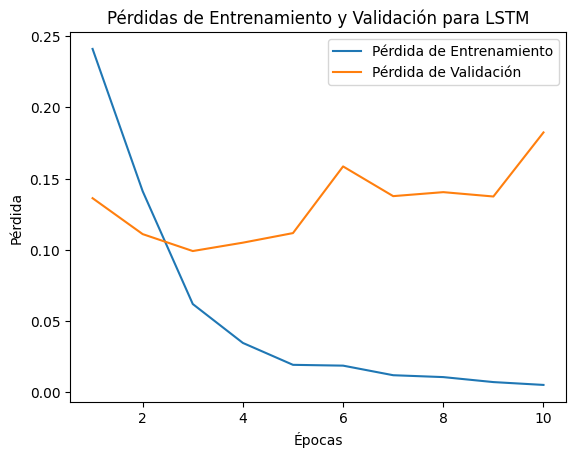

In [49]:
print("Inicio del entrenamiento de LSTM: \n")
lstm_train_perdidas, lstm_val_perdidas, lstm_val_accs = entrenamineto_y_validacion(lstm_modelo, lstm_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("LSTM",lstm_train_perdidas, lstm_val_perdidas, epochs)


Inicio del entrenamiento de RNN: 

Epoch: 1/10, Train perdida: 0.40344784943248696, Val perdida: 0.44541016282494533, Validación Acc: 0.8055798969317958
Epoch: 2/10, Train perdida: 0.23701611919453625, Val perdida: 0.2427018199999308, Validación Acc: 0.9108067009866853
Epoch: 3/10, Train perdida: 0.22168936566104158, Val perdida: 0.20536681064548565, Validación Acc: 0.9258659794158542
Epoch: 4/10, Train perdida: 0.14128335229575292, Val perdida: 0.18409409672021865, Validación Acc: 0.9421855669660667
Epoch: 5/10, Train perdida: 0.09400133667480819, Val perdida: 0.179788010774814, Validación Acc: 0.9377396906774068
Epoch: 6/10, Train perdida: 0.16061370404002787, Val perdida: 0.20907931690747592, Validación Acc: 0.9346932990034831
Epoch: 7/10, Train perdida: 0.13949116388444424, Val perdida: 0.1904407385083818, Validación Acc: 0.9407963917427457
Epoch: 8/10, Train perdida: 0.0711827616013139, Val perdida: 0.20479527497376057, Validación Acc: 0.9410721649828645
Epoch: 9/10, Train perdida

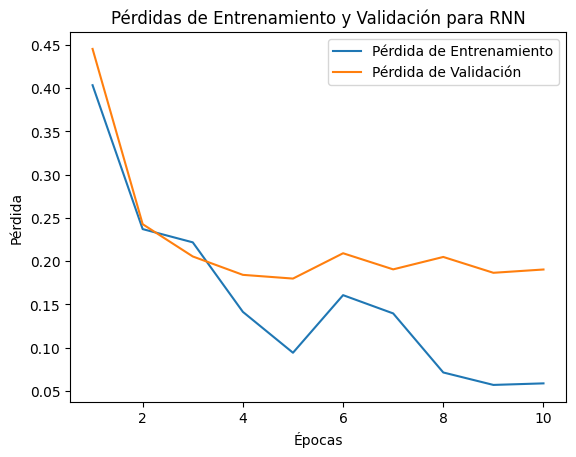

In [50]:
print("Inicio del entrenamiento de RNN: \n")
rnn_train_perdidas, rnn_val_perdidas, rnn_val_accs = entrenamineto_y_validacion(rnn_modelo, rnn_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("RNN",rnn_train_perdidas, rnn_val_perdidas, epochs)

Inicio del entrenamiento de MLP: 

Epoch: 1/10, Train perdida: 0.5268039860015623, Val perdida: 0.3454704372845974, Validación Acc: 0.8919561855571786
Epoch: 2/10, Train perdida: 0.24408746588738248, Val perdida: 0.15685650900236725, Validación Acc: 0.9467422680756481
Epoch: 3/10, Train perdida: 0.12882055336818865, Val perdida: 0.13873310915972153, Validación Acc: 0.9567474226361697
Epoch: 4/10, Train perdida: 0.09311570508334915, Val perdida: 0.15619787244251018, Validación Acc: 0.9575850515021491
Epoch: 5/10, Train perdida: 0.06521488113846667, Val perdida: 0.15264207862021123, Validación Acc: 0.9596649484536083
Epoch: 6/10, Train perdida: 0.053748044508471336, Val perdida: 0.14523575881438464, Validación Acc: 0.9611932989248295
Epoch: 7/10, Train perdida: 0.040665795729350036, Val perdida: 0.1616839443005804, Validación Acc: 0.963384020574314
Epoch: 8/10, Train perdida: 0.03479760355899997, Val perdida: 0.17400717930031157, Validación Acc: 0.9642860824299841
Epoch: 9/10, Train perd

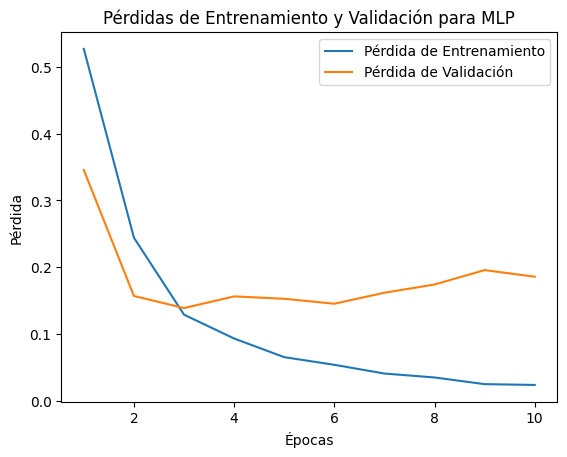

In [51]:
print("Inicio del entrenamiento de MLP: \n")
mlp_train_perdidas, mlp_val_perdidas, mlp_val_accs = entrenamineto_y_validacion(mlp_modelo, mlp_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("MLP",mlp_train_perdidas, mlp_val_perdidas, epochs)


--------- LSTM ---------

Puntuación de precisión: 0.9616
              precision    recall  f1-score   support

        Spam       0.95      0.98      0.97      8959
         Ham       0.97      0.93      0.95      6554

    accuracy                           0.96     15513
   macro avg       0.96      0.96      0.96     15513
weighted avg       0.96      0.96      0.96     15513



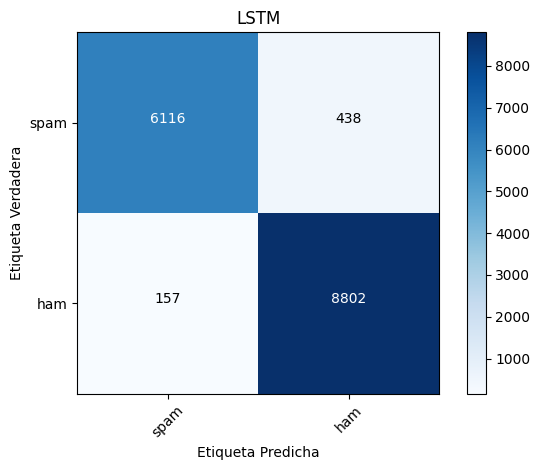

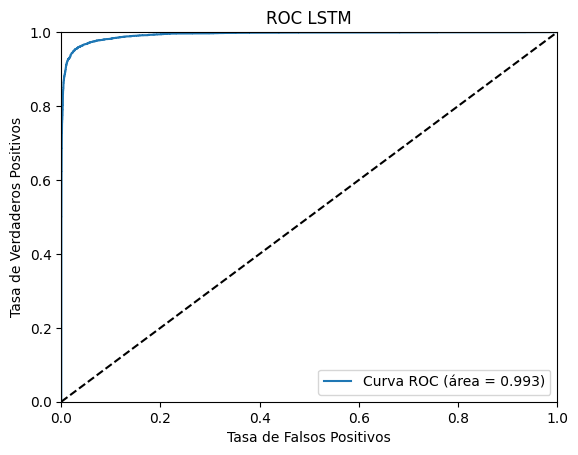

In [52]:
# Evaluar todos los modelos
resultados = []

# Modelo LSTM
lstm_puntuacion, lstm_nombre = evaluar_modelo(lstm_modelo, val_loader, device)
resultados.append((lstm_nombre, lstm_puntuacion))


--------- RNN ---------

Puntuación de precisión: 0.9479
              precision    recall  f1-score   support

        Spam       0.95      0.96      0.96      8959
         Ham       0.95      0.93      0.94      6554

    accuracy                           0.95     15513
   macro avg       0.95      0.95      0.95     15513
weighted avg       0.95      0.95      0.95     15513



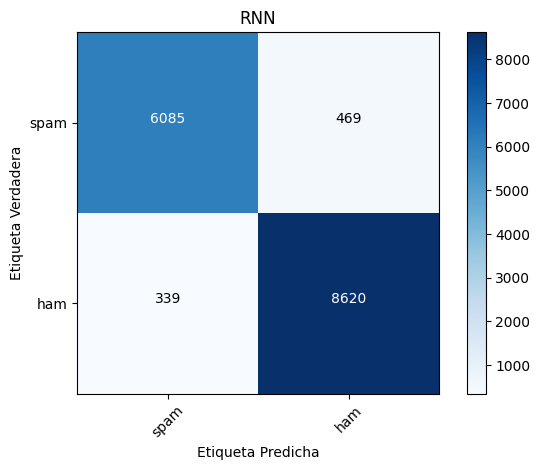

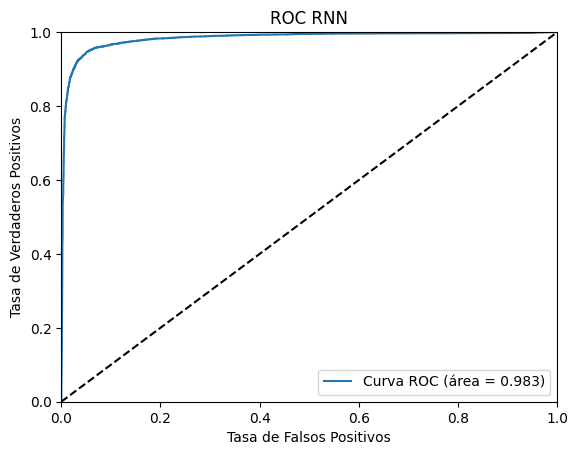

In [53]:
# Modelo RNN
rnn_puntuacion, rnn_nombre = evaluar_modelo(rnn_modelo, val_loader, device)
resultados.append((rnn_nombre, rnn_puntuacion))


--------- MLP ---------

Puntuación de precisión: 0.9636
              precision    recall  f1-score   support

        Spam       0.95      0.99      0.97      8959
         Ham       0.98      0.93      0.96      6554

    accuracy                           0.96     15513
   macro avg       0.97      0.96      0.96     15513
weighted avg       0.96      0.96      0.96     15513



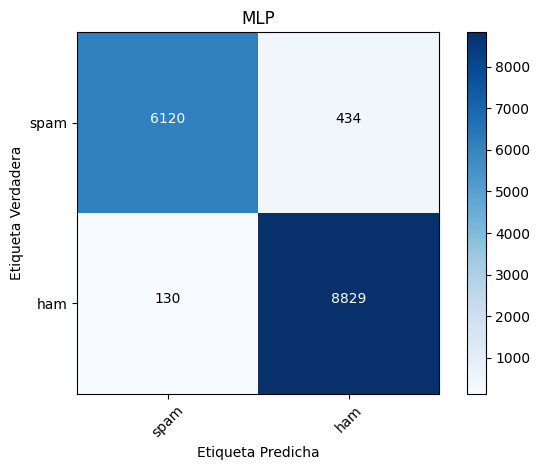

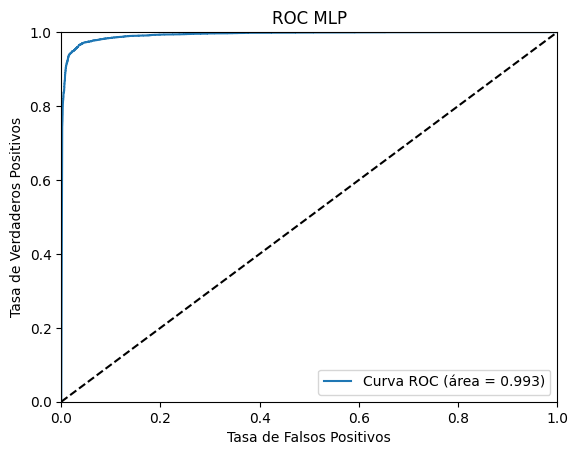

In [ ]:
# Modelo MLP
mlp_puntuacion, mlp_nombre = evaluar_modelo(mlp_modelo, val_loader, device)
resultados.append((mlp_nombre, mlp_puntuacion))

In [55]:
# Imprimir resultados
for nombre, puntuacion in resultados:
    print(f'{nombre}: {puntuacion:.4f}')

LSTM: 0.9616
RNN: 0.9479
MLP: 0.9636


---

## 7. Optimización de hiperparámetros para el mejor modelo

Utilizamos **Optuna** para encontrar los mejores hiperparámetros para el clasificador MLP.

[I 2025-03-29 22:17:44,547] A new study created in memory with name: no-name-294c03a9-71d5-43ff-9e36-4216b05ad9de


Epoch: 1/10, Train perdida: 0.6309959020189178, Val perdida: 0.5312689639858363, Validación Acc: 0.7129639175749317
Epoch: 2/10, Train perdida: 0.4556657016382622, Val perdida: 0.39844102327971115, Validación Acc: 0.8162216494992837
Epoch: 3/10, Train perdida: 0.3111347098219416, Val perdida: 0.3164559842077727, Validación Acc: 0.8684742267598811
Epoch: 4/10, Train perdida: 0.24465127460750696, Val perdida: 0.2992408925264152, Validación Acc: 0.8812242268287029
Epoch: 5/10, Train perdida: 0.2065072851243195, Val perdida: 0.28145712442004805, Validación Acc: 0.9017499999901684
Epoch: 6/10, Train perdida: 0.18006982569345817, Val perdida: 0.2731731035276172, Validación Acc: 0.9114149484437766
Epoch: 7/10, Train perdida: 0.15893919718889488, Val perdida: 0.2678774577018219, Validación Acc: 0.9183453607804997
Epoch: 8/10, Train perdida: 0.1385912905902151, Val perdida: 0.2714381209469026, Validación Acc: 0.9234999999557574
Epoch: 9/10, Train perdida: 0.12985021572407046, Val perdida: 0.272

[I 2025-03-29 22:49:58,919] Trial 0 finished with value: 0.925203608237591 and parameters: {'embedding_dim': 150, 'hidden_dim': 384, 'drop_prob': 0.7, 'learning_rate': 0.00010553723095226869}. Best is trial 0 with value: 0.925203608237591.


Epoch: 10/10, Train perdida: 0.12172851608753493, Val perdida: 0.29041588737331714, Validación Acc: 0.9189432989690721
Epoch: 1/10, Train perdida: 0.34374681868106655, Val perdida: 0.15593773698069385, Validación Acc: 0.9422680412371134
Epoch: 2/10, Train perdida: 0.10236446160387887, Val perdida: 0.1468987584267695, Validación Acc: 0.9507190721551168
Epoch: 3/10, Train perdida: 0.06156452181959258, Val perdida: 0.20399246573374372, Validación Acc: 0.9559097937701904
Epoch: 4/10, Train perdida: 0.04664186188503419, Val perdida: 0.16661576180305984, Validación Acc: 0.9548144329454481
Epoch: 5/10, Train perdida: 0.036837085059153486, Val perdida: 0.22016198909944618, Validación Acc: 0.9534149484536083
Epoch: 6/10, Train perdida: 0.027642233247018876, Val perdida: 0.3776957199033803, Validación Acc: 0.9564432989690722
Epoch: 7/10, Train perdida: 0.03660828247807321, Val perdida: 0.45653198337884116, Validación Acc: 0.9605025773195877
Epoch: 8/10, Train perdida: 0.022127514892727775, Val p

[I 2025-03-30 12:58:09,456] Trial 1 finished with value: 0.9618840206529676 and parameters: {'embedding_dim': 100, 'hidden_dim': 448, 'drop_prob': 0.30000000000000004, 'learning_rate': 0.0015985101995581244}. Best is trial 1 with value: 0.9618840206529676.


Epoch: 10/10, Train perdida: 0.012389613263878836, Val perdida: 0.4520023961217602, Validación Acc: 0.9613041237457511
Epoch: 1/10, Train perdida: 0.41810871242766035, Val perdida: 0.14310894752132525, Validación Acc: 0.9461159793372007
Epoch: 2/10, Train perdida: 0.25617754689846417, Val perdida: 0.15953205594503123, Validación Acc: 0.9559742267598811
Epoch: 3/10, Train perdida: 0.1609701436050867, Val perdida: 0.18013541344121176, Validación Acc: 0.9548788659351388
Epoch: 4/10, Train perdida: 0.16379522963256107, Val perdida: 0.3317240518088566, Validación Acc: 0.9623711340206186
Epoch: 5/10, Train perdida: 0.14134188479348148, Val perdida: 0.3420947317063307, Validación Acc: 0.9482061855571786
Epoch: 6/10, Train perdida: 0.11657415790916595, Val perdida: 0.4223114842015196, Validación Acc: 0.9558917526117305
Epoch: 7/10, Train perdida: 0.08948608809767952, Val perdida: 0.630677845089632, Validación Acc: 0.9540051546293435
Epoch: 8/10, Train perdida: 0.1486040686442453, Val perdida: 

[I 2025-03-30 13:17:12,696] Trial 2 finished with value: 0.9623711340206186 and parameters: {'embedding_dim': 100, 'hidden_dim': 64, 'drop_prob': 0.5, 'learning_rate': 0.008945117082536126}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.12661859001885511, Val perdida: 0.6443711209026936, Validación Acc: 0.9568118556258605
Epoch: 1/10, Train perdida: 0.5250431967918948, Val perdida: 0.3092254471840318, Validación Acc: 0.8748170102994467
Epoch: 2/10, Train perdida: 0.24880131239124142, Val perdida: 0.25301709837213004, Validación Acc: 0.9069871134364728
Epoch: 3/10, Train perdida: 0.15578446699003606, Val perdida: 0.23379488052397043, Validación Acc: 0.9234999999557574
Epoch: 4/10, Train perdida: 0.12435362292408397, Val perdida: 0.23942458483956985, Validación Acc: 0.9320515464261635
Epoch: 5/10, Train perdida: 0.10043160586365722, Val perdida: 0.24141080612364735, Validación Acc: 0.9308556700490185
Epoch: 6/10, Train perdida: 0.08846173658880632, Val perdida: 0.23997417905166285, Validación Acc: 0.9302654638732831
Epoch: 7/10, Train perdida: 0.07110251785562137, Val perdida: 0.2472582486352509, Validación Acc: 0.9383659794158542
Epoch: 8/10, Train perdida: 0.06516487174477163, Val perdid

[I 2025-03-30 13:27:39,264] Trial 3 finished with value: 0.9498711340206185 and parameters: {'embedding_dim': 50, 'hidden_dim': 448, 'drop_prob': 0.5, 'learning_rate': 0.00040795481363176876}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.05303117486656669, Val perdida: 0.24836549381869508, Validación Acc: 0.9498711340206185
Epoch: 1/10, Train perdida: 0.49286059313865094, Val perdida: 0.32298622314155717, Validación Acc: 0.8560309278596308
Epoch: 2/10, Train perdida: 0.2193298128107727, Val perdida: 0.278470482485196, Validación Acc: 0.8917525773195877
Epoch: 3/10, Train perdida: 0.14891989713258277, Val perdida: 0.2649774653164996, Validación Acc: 0.9110180412371134
Epoch: 4/10, Train perdida: 0.12421319480474698, Val perdida: 0.2846124083110967, Validación Acc: 0.9053762886942047
Epoch: 5/10, Train perdida: 0.09204309575669813, Val perdida: 0.272218599212692, Validación Acc: 0.9247061856014213
Epoch: 6/10, Train perdida: 0.08437123650334827, Val perdida: 0.3215454874925085, Validación Acc: 0.9141855670004776
Epoch: 7/10, Train perdida: 0.08368450954851846, Val perdida: 0.2907809566826435, Validación Acc: 0.9286726804123712
Epoch: 8/10, Train perdida: 0.0681358749334772, Val perdida: 0.3

[I 2025-03-30 14:01:11,503] Trial 4 finished with value: 0.9324381443643078 and parameters: {'embedding_dim': 150, 'hidden_dim': 256, 'drop_prob': 0.30000000000000004, 'learning_rate': 0.00019476006042364402}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.055625877753679526, Val perdida: 0.3542458507251571, Validación Acc: 0.9262345360726425
Epoch: 1/10, Train perdida: 0.4554640454282925, Val perdida: 0.26851790366099054, Validación Acc: 0.8744304123613024
Epoch: 2/10, Train perdida: 0.18607050841575482, Val perdida: 0.16954746866195472, Validación Acc: 0.9403994845360825
Epoch: 3/10, Train perdida: 0.1156789131075592, Val perdida: 0.1695074611410652, Validación Acc: 0.9436855670103093
Epoch: 4/10, Train perdida: 0.07846275622802812, Val perdida: 0.2152312646783197, Validación Acc: 0.9237396907560604
Epoch: 5/10, Train perdida: 0.06230584025771373, Val perdida: 0.17736371232235093, Validación Acc: 0.9546855669660667
Epoch: 6/10, Train perdida: 0.05425049261673707, Val perdida: 0.19901327362077637, Validación Acc: 0.9478092783505154
Epoch: 7/10, Train perdida: 0.04333709887483667, Val perdida: 0.18145720605815271, Validación Acc: 0.9572809278350516
Epoch: 8/10, Train perdida: 0.033463089265467864, Val perdi

[I 2025-03-30 14:34:21,501] Trial 5 finished with value: 0.9585979381787408 and parameters: {'embedding_dim': 150, 'hidden_dim': 192, 'drop_prob': 0.4, 'learning_rate': 0.0006526171171406461}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.029477293638281193, Val perdida: 0.24856207743347095, Validación Acc: 0.9585979381787408
Epoch: 1/10, Train perdida: 0.5813214298034936, Val perdida: 0.20330762305517786, Validación Acc: 0.9367087628423553
Epoch: 2/10, Train perdida: 0.38255501773058026, Val perdida: 0.21970343708766374, Validación Acc: 0.9439896906774069
Epoch: 3/10, Train perdida: 0.30903765400596045, Val perdida: 0.3774888021775435, Validación Acc: 0.959242268075648
Epoch: 4/10, Train perdida: 0.27466048407474086, Val perdida: 0.7615519297001979, Validación Acc: 0.9328247423024522
Epoch: 5/10, Train perdida: 0.2903629441518524, Val perdida: 0.34461354269698913, Validación Acc: 0.9519149484093656
Epoch: 6/10, Train perdida: 0.2787127056878024, Val perdida: 1.0497237835943545, Validación Acc: 0.9378041236670975
Epoch: 7/10, Train perdida: 0.48520213640195337, Val perdida: 0.7569456749778126, Validación Acc: 0.9483891752577319
Epoch: 8/10, Train perdida: 0.14201707072210373, Val perdida: 

[I 2025-03-30 18:39:12,091] Trial 6 finished with value: 0.959242268075648 and parameters: {'embedding_dim': 300, 'hidden_dim': 320, 'drop_prob': 0.30000000000000004, 'learning_rate': 0.007005776010959865}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.1413077681280949, Val perdida: 1.3844062689883807, Validación Acc: 0.9376932989690722
Epoch: 1/10, Train perdida: 0.4016190540348262, Val perdida: 0.2209281538949185, Validación Acc: 0.9196984535640048
Epoch: 2/10, Train perdida: 0.13641181194746715, Val perdida: 0.1806318657261502, Validación Acc: 0.9324201030829518
Epoch: 3/10, Train perdida: 0.09383671335191482, Val perdida: 0.18817347616686955, Validación Acc: 0.9462448453165822
Epoch: 4/10, Train perdida: 0.06769899110012031, Val perdida: 0.21945081226474883, Validación Acc: 0.9442474226361698
Epoch: 5/10, Train perdida: 0.05466184599487309, Val perdida: 0.18903718382689008, Validación Acc: 0.9475721649287903
Epoch: 6/10, Train perdida: 0.04186306807711487, Val perdida: 0.21566684311639864, Validación Acc: 0.9494020618114275
Epoch: 7/10, Train perdida: 0.03431764864594337, Val perdida: 0.2395449915251541, Validación Acc: 0.9531391752134893
Epoch: 8/10, Train perdida: 0.02600710867055205, Val perdida:

[I 2025-03-30 22:48:00,338] Trial 7 finished with value: 0.9549432989248295 and parameters: {'embedding_dim': 200, 'hidden_dim': 320, 'drop_prob': 0.30000000000000004, 'learning_rate': 0.0006931836608553383}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.019399613714126986, Val perdida: 0.31244989339632495, Validación Acc: 0.9549432989248295
Epoch: 1/10, Train perdida: 0.8686634197883808, Val perdida: 0.3323365131604303, Validación Acc: 0.902523195866457
Epoch: 2/10, Train perdida: 0.8348463424168817, Val perdida: 0.22538596677411463, Validación Acc: 0.9078711340107869
Epoch: 3/10, Train perdida: 0.4967783475220664, Val perdida: 0.2903563499105038, Validación Acc: 0.9297499999557574
Epoch: 4/10, Train perdida: 0.6006105938867103, Val perdida: 0.3707431993936909, Validación Acc: 0.9112577319145203
Epoch: 5/10, Train perdida: 0.5061117001077368, Val perdida: 0.41328009128877796, Validación Acc: 0.9149948453165822
Epoch: 6/10, Train perdida: 0.4199137027102256, Val perdida: 0.9350074456025338, Validación Acc: 0.9021082473784378
Epoch: 7/10, Train perdida: 0.5911111435342856, Val perdida: 0.8601985549343001, Validación Acc: 0.8989329897251326
Epoch: 8/10, Train perdida: 0.5255379378663988, Val perdida: 1.1277

[I 2025-03-31 14:47:25,554] Trial 8 finished with value: 0.9297499999557574 and parameters: {'embedding_dim': 300, 'hidden_dim': 256, 'drop_prob': 0.6000000000000001, 'learning_rate': 0.006170279045409646}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 1.140474599509668, Val perdida: 1.301011132952018, Validación Acc: 0.8963273195876289
Epoch: 1/10, Train perdida: 0.5874908730822086, Val perdida: 0.44606728006883994, Validación Acc: 0.8254793814777099
Epoch: 2/10, Train perdida: 0.3669264005404953, Val perdida: 0.2605320386050903, Validación Acc: 0.8856237112861318
Epoch: 3/10, Train perdida: 0.2519506358117023, Val perdida: 0.21114115275673032, Validación Acc: 0.9176365978939017
Epoch: 4/10, Train perdida: 0.19078599152323056, Val perdida: 0.18706117651434903, Validación Acc: 0.9345463917427457
Epoch: 5/10, Train perdida: 0.15389607492801421, Val perdida: 0.18501038739803372, Validación Acc: 0.9389639174815305
Epoch: 6/10, Train perdida: 0.12482485647170143, Val perdida: 0.2053690089508123, Validación Acc: 0.9209613401865222
Epoch: 7/10, Train perdida: 0.11046288601516058, Val perdida: 0.19030991159235464, Validación Acc: 0.9418453608591532
Epoch: 8/10, Train perdida: 0.09322454550327378, Val perdida: 0.

[I 2025-03-31 19:01:38,745] Trial 9 finished with value: 0.9513530927835051 and parameters: {'embedding_dim': 200, 'hidden_dim': 128, 'drop_prob': 0.6000000000000001, 'learning_rate': 0.000271889968902132}. Best is trial 2 with value: 0.9623711340206186.


Epoch: 10/10, Train perdida: 0.07661024954231899, Val perdida: 0.18663765775932709, Validación Acc: 0.9513530927835051
Mejores hiperparámetros encontrados: {'embedding_dim': 100, 'hidden_dim': 64, 'drop_prob': 0.5, 'learning_rate': 0.008945117082536126}
Inicio del entrenamiento de MLP optimizado: 

Epoch: 1/10, Train perdida: 0.5147524947669133, Val perdida: 0.17821243118072294, Validación Acc: 0.9456185567010309
Epoch: 2/10, Train perdida: 0.23120761318175476, Val perdida: 0.17743943335161996, Validación Acc: 0.9446520618556701
Epoch: 3/10, Train perdida: 0.22873149784490615, Val perdida: 0.19932967523858416, Validación Acc: 0.946069587628866
Epoch: 4/10, Train perdida: 0.15326242305095403, Val perdida: 0.22446502564647763, Validación Acc: 0.9578608247422681
Epoch: 5/10, Train perdida: 0.19597810873828225, Val perdida: 0.3452494801792614, Validación Acc: 0.9401237112959636
Epoch: 6/10, Train perdida: 0.18796281809851798, Val perdida: 0.32708086792768515, Validación Acc: 0.946051546347

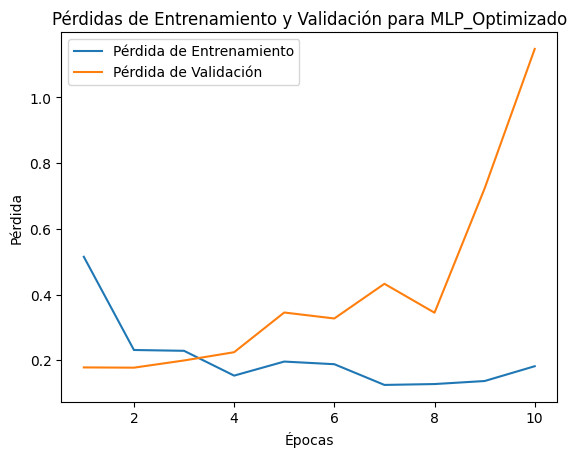

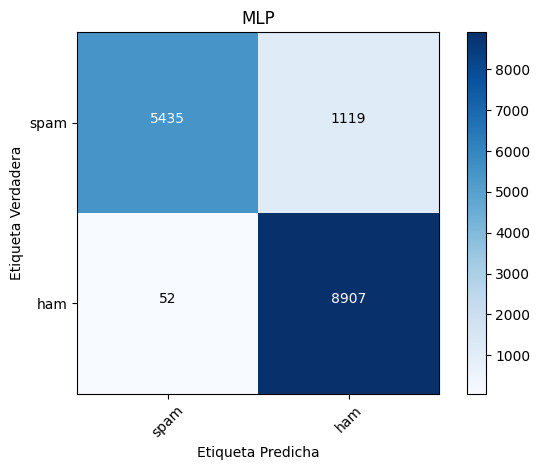

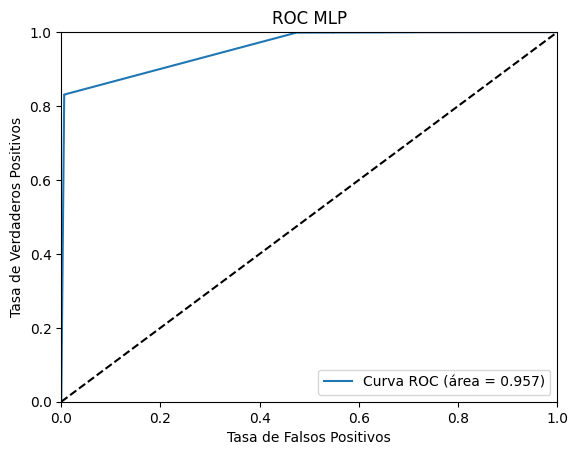

In [57]:
import optuna

# Definir la función objetivo para Optuna
def objetivo(intento):
    embedding_dim = intento.suggest_int("embedding_dim", 50, 300, step=50)
    hidden_dim = intento.suggest_int("hidden_dim", 64, 512, step=64)
    drop_prob = intento.suggest_float("drop_prob", 0.2, 0.7, step=0.1)
    learning_rate = intento.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    
    # Definir el modelo MLP con los parámetros sugeridos
    modelo = MLP(vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob).to(device)
    optimizador = optim.Adam(modelo.parameters(), lr=learning_rate)
    
    # Entrenar el modelo
    _, _, val_accs = entrenamineto_y_validacion(modelo, optimizador, func_perdida, train_loader, val_loader, epochs=10, device=device)

    # Devolver la mejor precisión en validación
    return max(val_accs)

# Crear un estudio y optimizar
estudio = optuna.create_study(direction="maximize")
estudio.optimize(objetivo, n_trials=10)

# Obtener los mejores hiperparámetros
mejores_parametros = estudio.best_params
print("Mejores hiperparámetros encontrados:", mejores_parametros)

# Entrenar el modelo MLP con los mejores hiperparámetros
mlp_optimo = MLP(vocab_size, mejores_parametros["embedding_dim"], mejores_parametros["hidden_dim"], output_size, n_layers, mejores_parametros["drop_prob"]).to(device)
mlp_optimizador = optim.Adam(mlp_optimo.parameters(), lr=mejores_parametros["learning_rate"])

print("Inicio del entrenamiento de MLP optimizado: \n")
mlp_train_perdidas, mlp_val_perdidas, mlp_val_accs = entrenamineto_y_validacion(mlp_optimo, mlp_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("MLP_Optimizado", mlp_train_perdidas, mlp_val_perdidas, epochs)

# Evaluar el modelo optimizado
mlp_puntuacion, mlp_nombre = evaluar_modelo(mlp_optimo, val_loader, device)
print(f"MLP Optimizado - Precisión: {mlp_puntuacion:.4f}")
